### Import

In [1]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score, f1_score  
from sklearn.metrics import roc_auc_score
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

In [2]:
print(xgb.__version__)

1.7.5


In [3]:
import sys

print(sys.version)

3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]


### Start global timer

In [4]:
tic = time.time()

### Data 

In [5]:
data = pd.read_csv('hmda_train_preprocessed.csv')

In [6]:
y_name = 'high_priced'

### Split data into train and validation partitions

In [7]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### XGBOOST MODEL
### Retrain most accurate model above 0.8 AIR to debug

In [8]:
# params dict for remediated models
rem_params = {'max_depth': 9,
 'learning_rate': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'min_child_weight': 5,
 'gamma': 0.1,
 'reg_alpha': 0.1,
 'reg_lambda': 1.0,
 'n_jobs': -1,
 'random_state': 12345}


rem_x_names = ['term_360',
 'no_intro_rate_period_std',
 'property_value_std',
 'intro_rate_period_std',
 'income_std',
 'debt_to_income_ratio_std',
 'conforming']

# Fit the remediated XGBoost model
rem_xgb = xgb.XGBClassifier(**rem_params)
rem_xgb.fit(train[rem_x_names], train[y_name])

# Make predictions on the validation dataset using the remediated XGBoost model
rem_xgb_preds = rem_xgb.predict_proba(valid[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
rem_auc = roc_auc_score(valid[y_name], rem_xgb_preds)
print('Remediated XGB retrained with AUC: %.4f.' % rem_auc)

train_rem_xgb_preds = rem_xgb.predict_proba(train[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
train_rem_auc = roc_auc_score(train[y_name], train_rem_xgb_preds)
print('Remediated XGB with train AUC: %.4f.' % train_rem_auc)

Remediated XGB retrained with AUC: 0.7765.
Remediated XGB with train AUC: 0.7991.


### Sensitivity Analysis: Stress Testing

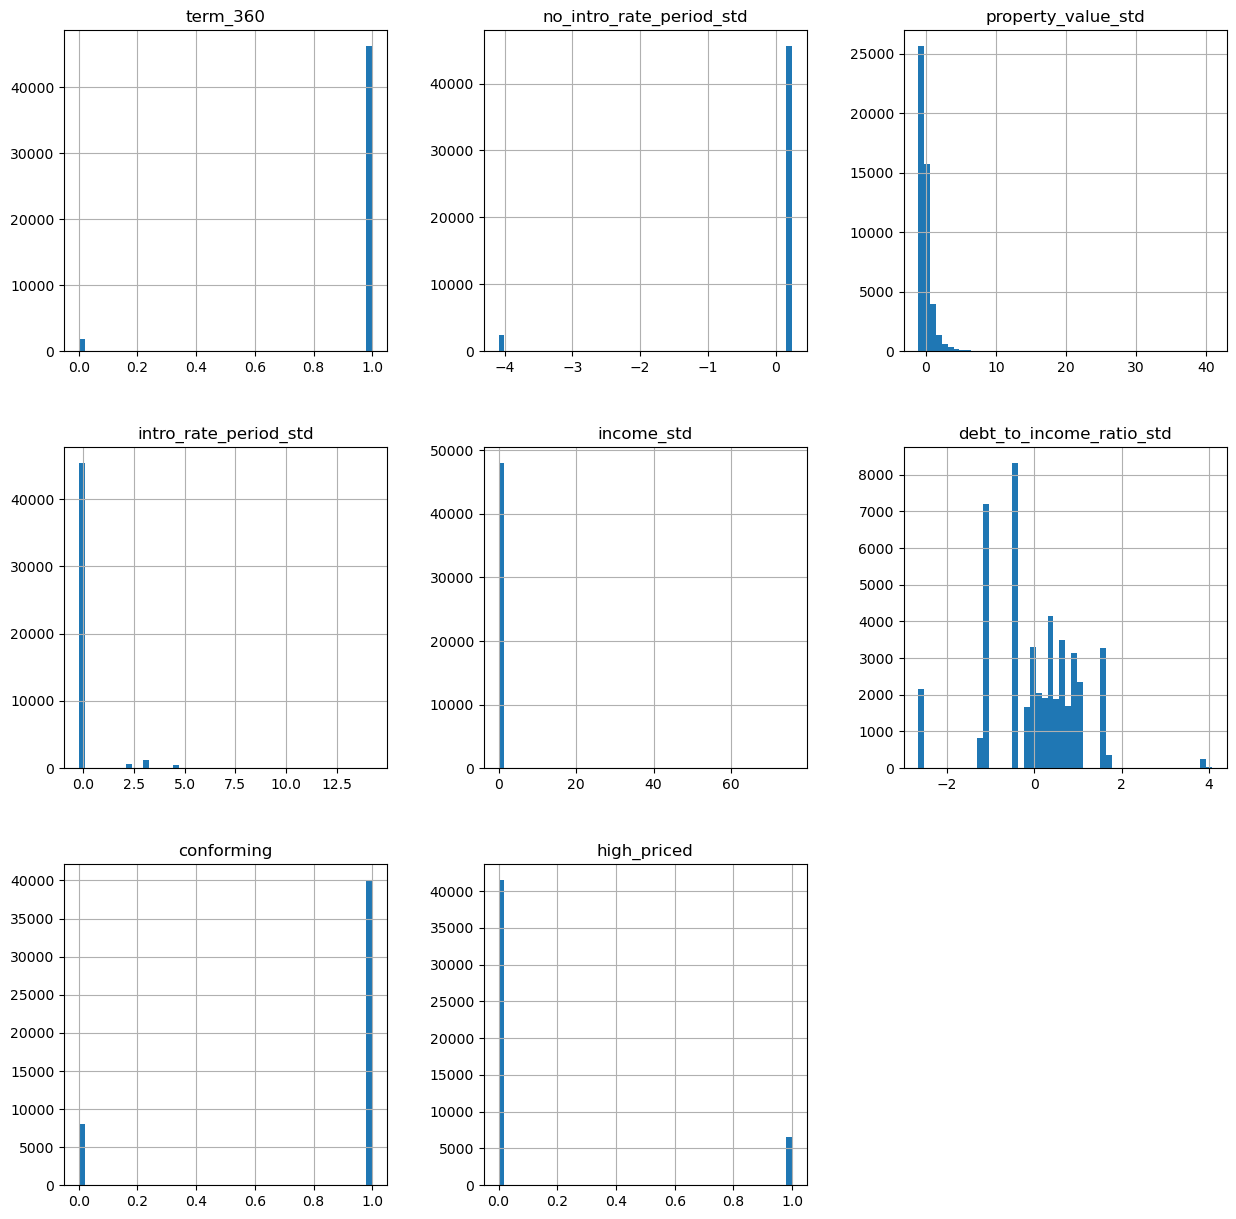

In [9]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

In [10]:
# Make predictions on the validation dataset using the remediated XGBoost model
rec_rem_xgb_preds = rem_xgb.predict_proba(rec_valid[rem_x_names])[:, 1]

# Calculate the AUC using sklearn's roc_auc_score function
rem_auc = roc_auc_score(rec_valid[y_name], rec_rem_xgb_preds)
print('Remediated XGB retrained with AUC: %.4f.' % rem_auc)

Remediated XGB retrained with AUC: 0.6536.


Based on the reduced AUC, we need to monitor this model carefully.This model will fail quickly if the recession happens.

### Residual Analysis

In [11]:
# shortcut names
yhat_name = 'phat'
r_name = 'r' 

# calculate predictions
rem_xgb_phat = pd.DataFrame(rem_xgb.predict_proba(data[rem_x_names])[:, 1], columns=['phat']) 
rem_xgb_phat = pd.concat([data.reset_index(drop=True), rem_xgb_phat], axis=1)

# calculate logloss residuals
rem_xgb_phat[r_name] = -rem_xgb_phat[y_name]*np.log(rem_xgb_phat[yhat_name]) -\
                       (1 - rem_xgb_phat[y_name])*np.log(1 - rem_xgb_phat[yhat_name])   

#### Plot

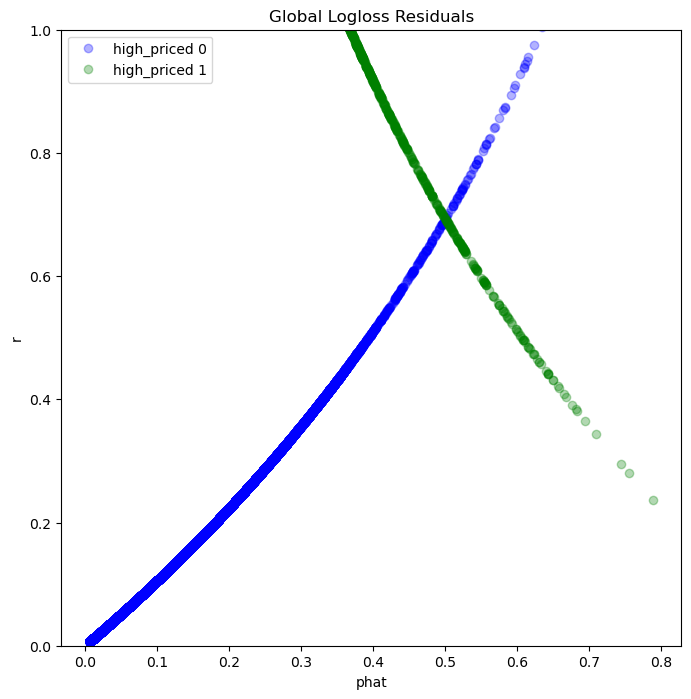

In [12]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot groups with different colors
color_list = ['blue', 'green']
c_idx = 0
groups = rem_xgb_phat.groupby(y_name)  # Define groups for levels of PAY_0
for name, group in groups:
    ax.plot(group.phat, group.r,
            label=' '.join([y_name, str(name)]),
            marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# Annotate the plot
ax.set_xlabel(yhat_name)
ax.set_ylabel(r_name)
ax.set_ylim(0, 1)
ax.legend(loc=2)
plt.title('Global Logloss Residuals')
plt.show()

Based on the plots, it might be possible to say that residuals are very unbalanced. Also,there are noticable outliers. 

### Remediation: Remove Outliers

In [13]:
rem_xgb_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.007370,4.910374
87875,87875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.772170,-0.165360,0.244394,-0.215304,1.499163,0.035225,-0.059493,1,0.007519,4.890380
9460,9460,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1.420391,0.139259,0.244394,-0.215304,1.005806,0.033493,-1.156406,1,0.007673,4.870016
145443,145443,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,2.167922,0.178503,0.244394,-0.215304,1.560832,0.051163,-0.150903,1,0.007678,4.869377
115993,115993,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,2.036004,-0.359985,0.244394,-0.215304,1.900015,0.035918,0.123326,1,0.008373,4.782790


#### Remove worst outliers

In [14]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_xgb_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

### Remediation: Down-sample to Increase Signal from High-priced Loans

In [15]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

In [16]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_xgb2 = xgb.XGBClassifier(**rem_params)
rem_xgb2.fit(rem_train[rem_x_names], rem_train[y_name]) 
rec_xgb_preds2 = rem_xgb.predict_proba(rem_valid[rem_x_names])[:, 1]
rem_auc2 = roc_auc_score(rem_valid[y_name], rec_xgb_preds2)
print('Remediated XGB under-sampled AUC: %.4f.' % rem_auc2)

Remediated train data rows = 61518, columns = 23
Remediated validation data rows = 26393, columns = 23
Remediated XGB under-sampled AUC: 0.7892.


In [17]:
# calculate predictions
rem_xgb_phat2 = pd.DataFrame(rem_xgb.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
rem_xgb_phat2 = pd.concat([valid.reset_index(drop=True), rem_xgb_phat2], axis=1)
rec_xgb_preds3 = rem_xgb2.predict_proba(valid[rem_x_names])[:, 1]
rem_auc3 = roc_auc_score(valid[y_name], rec_xgb_preds3)
print('Remediated XBOOST true AUC: %.4f.' % rem_auc3) 

Remediated XBOOST true AUC: 0.7940.


Fortunately, a new auc increases!

In [18]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 7.83 s.
